# CIFAR-10

**Task description:** Take the CIFAR-10 dataset. Train a network, which is able to predict for a given input image whether an animal or a vessel is included, and whether the depicted object can fly, walk, jump or swim.

## Data

**Groud truth:**


| label |  name  | animal or vessel  | fly, walk, jump, or swim  |
|---|---|---|---|
| 0  |airplane | none | fly |
| 1  |automobile | none | none |
| 2  |bird | animal | fly, walk, jump |
| 3  |cat | animal | walk, jump, swim |
| 4  |deer | animal | walk, jump, swim |
| 5  |dog | animal | walk, jump, swim |
| 6  |frog | animal | jump, swim |
| 7  |horse | animal | walk, jump, swim |
| 8  |ship | vessel | swim |
| 9  |truck | none | none |

In [1]:
label_map = {
    0: {
        "label_name": "airplane",
        "animal_vessel": "none",
        "movement": ["fly"],
    },
    1: {
        "label_name": "automobile",
        "animal_vessel": "none",
        "movement": ["none"],
    },
    2: {
        "label_name": "bird",
        "animal_vessel": "animal",
        "movement": ["fly", "walk", "jump"],
    },
    3: {
        "label_name": "cat",
        "animal_vessel": "animal",
        "movement": ["walk", "jump", "swim"],
    },
    4: {
        "label_name": "deer",
        "animal_vessel": "animal",
        "movement": ["walk", "jump", "swim"],
    },
    5: {
        "label_name": "dog",
        "animal_vessel": "animal",
        "movement": ["walk", "jump", "swim"],
    },
    6: {
        "label_name": "frog",
        "animal_vessel": "animal",
        "movement": ["jump", "swim"],
    },
    7: {
        "label_name": "horse",
        "animal_vessel": "animal",
        "movement": ["walk", "jump", "swim"],
    },
    8: {
        "label_name": "ship",
        "animal_vessel": "vessel",
        "movement": ["swim"],
    },
    9: {
        "label_name": "truck",
        "animal_vessel": "none",
        "movement": ["none"]
    }
}
movement_map = {
    "fly": 0,
    "walk": 1,
    "jump": 2,
    "swim": 3,
    "none": 4
}
animal_vessel_map = {
    "animal": 0,
    "vessel": 1,
    "none": 2
}

In [2]:
def transform_target(y):
    animal_vessel_idx = animal_vessel_map[label_map[y]["animal_vessel"]]
    movement_idx = [movement_map[m] for m in label_map[y]["movement"]]
    return {
        "animal_vessel": torch.tensor(animal_vessel_idx),
        "movement": torch.zeros(5, dtype=torch.float).scatter_(0, torch.tensor(movement_idx), value=1)
    }

In [3]:
import torch
from torchvision import datasets, transforms

training_data = datasets.CIFAR10(
    root="/tmp",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ]),
    target_transform=transforms.Lambda(lambda y: transform_target(y))
)
test_data = datasets.CIFAR10(
    root="/tmp",
    train=False,
    download=True,
        transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ]),
    target_transform=transforms.Lambda(lambda y: transform_target(y))
)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


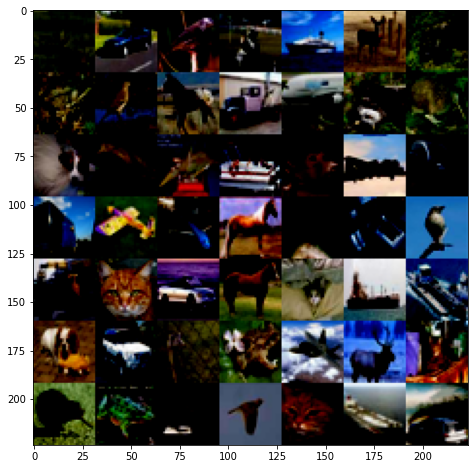

In [4]:
import matplotlib.pyplot as plt

n = 49
sample = torch.stack([training_data[i.item()][0] for i in torch.randint(0, len(training_data), (n, ))])
plt.figure(figsize=(8, 8))
plt.imshow(torch.hstack(torch.unbind(sample.movedim(1, 3).reshape(int(n**(1/2)), -1, 32, 3))))

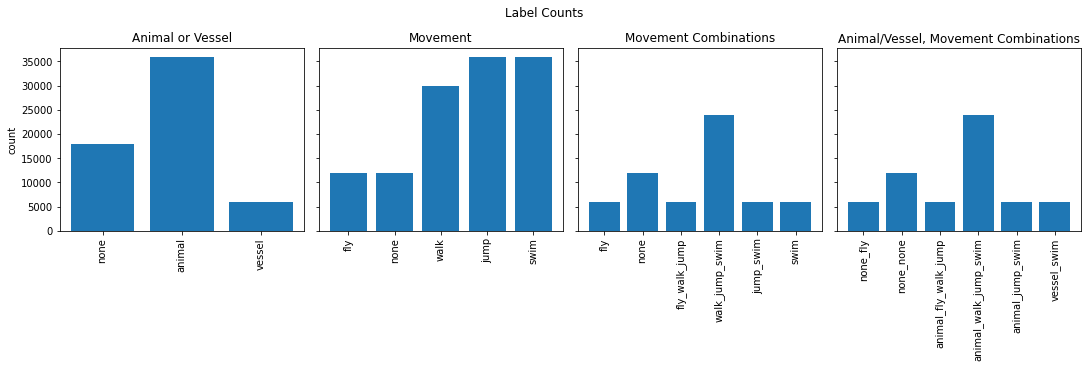

In [5]:
# label distribution can be computed based on the frequencies of the original labels
# https://www.cs.toronto.edu/~kriz/cifar.html
import collections

images_per_class = 5000 + 1000
animal_vessel_freq = collections.defaultdict(int)
movement_freq = collections.defaultdict(int)
movement_comb_freq = collections.defaultdict(int)
animal_movement_comb_freq = collections.defaultdict(int)
for label in label_map.values():
    animal_vessel_freq[label["animal_vessel"]] += images_per_class
    for m in label["movement"]:
        movement_freq[m] += images_per_class
    movement_comb_freq["_".join(label["movement"])] += images_per_class
    animal_movement_comb_freq["_".join([label["animal_vessel"]]+label["movement"])] += images_per_class
    

fig, ax = plt.subplots(1, 4, sharey=True, constrained_layout=True, figsize=(15, 5))
for i, d in enumerate([animal_vessel_freq, movement_freq, movement_comb_freq, animal_movement_comb_freq]):
    ax[i].bar(range(len(d)), list(d.values()), tick_label=list(d.keys()))
    ax[i].tick_params("x", labelrotation=90)
ax[0].set_ylabel("count")
ax[0].set_title("Animal or Vessel")
ax[1].set_title("Movement")
ax[2].set_title("Movement Combinations")
ax[3].set_title("Animal/Vessel, Movement Combinations")
fig.suptitle("Label Counts")
#plt.savefig("label-counts.pdf")
plt.show()

In [6]:
import numpy as np

animal_vessel_weights = np.zeros(3)
movement_weights = np.zeros(5)
for l, i in animal_vessel_map.items():
    animal_vessel_weights[i] = (animal_vessel_freq[l]/sum(animal_vessel_freq.values()))**-1
for l, i in movement_map.items():
    movement_weights[i] = (movement_freq[l]/sum(movement_freq.values()))**-1

weight = {
    "animal_vessel": torch.from_numpy(animal_vessel_weights / sum(animal_vessel_weights)).float(),
    "movement": torch.from_numpy(movement_weights / sum(movement_weights)).float()
}

In [7]:
weight

{'animal_vessel': tensor([0.1111, 0.6667, 0.2222]),
 'movement': tensor([0.3261, 0.1304, 0.1087, 0.1087, 0.3261])}

## Model

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class SmallAlexNet(nn.Module):
    # https://en.wikipedia.org/wiki/AlexNet
    def __init__(self, dropout=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 120, kernel_size=5, padding=1),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.linear_relu_stack = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(120 * 6 * 6, 84),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(84, 10),
            nn.ReLU(inplace=True)
        )
        self.animal_vessel = nn.Sequential(
            nn.Linear(10, 3),
            #nn.Softmax()
        )
        self.movement = nn.Sequential(
            nn.Linear(10, 5),
            #nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear_relu_stack(x)
        return {
            "animal_vessel": self.animal_vessel(x),
            "movement": self.movement(x),
        }

In [9]:
def loss_fn(output, target, weight):
    if weight is not None:
        cross_entropy = F.cross_entropy(output["animal_vessel"], target["animal_vessel"], weight=weight["animal_vessel"])
        binary_cross_entropy = F.binary_cross_entropy_with_logits(output["movement"], target["movement"], weight=weight["movement"])
    else:
        cross_entropy = F.cross_entropy(output["animal_vessel"], target["animal_vessel"])
        binary_cross_entropy = F.binary_cross_entropy_with_logits(output["movement"], target["movement"])
    return cross_entropy + binary_cross_entropy

## Training

In [10]:
from tqdm import tqdm
import sys

def train_loop(epoch_index):
    size = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)
    running_loss = 0
    for i, (X, y) in enumerate(tqdm(train_dataloader, desc=f"Train loop", file=sys.stdout)):
        pred = model(X)
        loss = loss_fn(pred, y, weight)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000
            n_iter = epoch_index * num_batches + i + 1
            writer.add_scalar("Loss/train", last_loss, n_iter)
            running_loss = 0
    return last_loss
            
def test_loop(epoch_index, best_loss, save=True):
    num_batches = len(test_dataloader)
    test_loss = 0
    with torch.no_grad():
        for X, y in tqdm(test_dataloader, desc=f"Test loop", file=sys.stdout):
            pred = model(X)
            test_loss += loss_fn(pred, y, weight).item()
    test_loss /= num_batches
    return test_loss

In [11]:
from torch.utils.data import DataLoader

learning_rate = 1e-3
batch_size = 8

model = SmallAlexNet()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

weight = None

In [12]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter


timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter(f"runs/cifar10_{timestamp}")
best_loss = np.inf

epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(t)
    test_loss = test_loop(t, best_loss)
    writer.add_scalars(
        "Training vs. Test Loss",
        {"Training": train_loss, "Test": test_loss},
        t+1
    )
    writer.flush()
    
    if test_loss < best_loss:
        best_loss = test_loss
        model_path = f"models/model_{timestamp}_{t}"
        torch.save(model.state_dict(), model_path)
        
    print(f"Train loss: {train_loss:>7f}, Test loss: {test_loss:>8f}")
    
train_time = datetime.now() - datetime.strptime(timestamp, "%Y%m%d_%H%M%S")
print(f"Finished Training (training time: {str(train_time)})")

Epoch 1
-------------------------------
Test loop: 100%|██████████| 1250/1250 [00:10<00:00, 120.66it/s]
Train loss: 0.891145, Test loss: 0.895912
Epoch 2
-------------------------------
Test loop: 100%|██████████| 1250/1250 [00:12<00:00, 100.09it/s]
Train loss: 0.840081, Test loss: 0.830628
Epoch 3
-------------------------------
Test loop: 100%|██████████| 1250/1250 [00:08<00:00, 154.96it/s]
Train loss: 0.797540, Test loss: 0.806517
Epoch 4
-------------------------------
Test loop: 100%|██████████| 1250/1250 [00:09<00:00, 133.06it/s]
Train loss: 0.758289, Test loss: 0.767504
Epoch 5
-------------------------------
Test loop: 100%|██████████| 1250/1250 [00:08<00:00, 150.27it/s]
Train loss: 0.743899, Test loss: 0.785662
Epoch 6
-------------------------------
Test loop: 100%|██████████| 1250/1250 [00:07<00:00, 161.90it/s]
Train loss: 0.740527, Test loss: 0.747757
Epoch 7
-------------------------------
Test loop: 100%|██████████| 1250/1250 [00:11<00:00, 105.28it/s]
Train loss: 0.715735

## Evaluation

In [13]:
!tensorboard --logdir=runs


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.6.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [15]:
mod = SmallAlexNet()
mod.load_state_dict(torch.load("models/model_20220331_122653_18"))
mod.eval()

SmallAlexNet(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (linear_relu_stack): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4320, out_features=84, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=84, out

In [16]:
y_pred = collections.defaultdict(list)
y_true = collections.defaultdict(list)
for x, y in test_dataloader:
    pred = mod(x)
    for i in range(batch_size):
        animal_vessel_pred = (np.arange(3) == pred["animal_vessel"][i].argmax().item()).astype(int)
        movement_pred = np.array(pred["movement"][i] > 0.5, dtype=int)
        animal_vessel_true = (np.arange(3) == y["animal_vessel"][i].item()).astype(int)
        movement_true = y["movement"][i].detach().numpy()
        for a, idx in animal_vessel_map.items():
            if a == "none":
                a = "none_a"
            y_pred[a].append(animal_vessel_pred[idx])
            y_true[a].append(animal_vessel_true[idx])
        for m, idx in movement_map.items():
            if m == "none":
                m = "none_m"
            y_pred[m].append(movement_pred[idx])
            y_true[m].append(movement_true[idx])

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_class_metrics(y_pred, y_true):
    metrics = collections.defaultdict(dict)
    for c in ["animal", "vessel", "none_a", "fly", "walk", "jump", "swim", "none_m"]:
        for m in [accuracy_score, precision_score, recall_score, f1_score]:
            metrics[c][m.__name__] = m(y_true[c], y_pred[c])
    return dict(metrics)

In [18]:
import pandas as pd
pd.DataFrame(compute_class_metrics(y_pred, y_true)).T

,accuracy_score,precision_score,recall_score,f1_score
animal,0.9105,0.913093,0.940333,0.926513
vessel,0.9411,0.778833,0.574000,0.660910
none_a,0.8834,0.797341,0.819667,0.808350
fly,0.8394,0.821895,0.251500,0.385145
walk,0.8268,0.850043,0.793600,0.820852
jump,0.9148,0.936123,0.920833,0.928415
swim,0.8074,0.837028,0.843167,0.840086
none_m,0.9232,0.888398,0.704500,0.785834
